# Open-Ephys Data Analysis Pipeline V2

### This Juypter notebooks was made to be an easy to use pipeline for analysing open ephys data. Contained within this notebook is code to load open-ephys data, visualize raw traces, plot the frequency distribution, and plot a histogram with neuronal spikes configured in 1 second bins (i.e. how many spikes per minute?)

### Part 1: Loading packages

### Part 2: Loading Open-Ephys experimental data

### Part 3: Visualizing data - raw traces

### Part 4: Plotting frequency content (Power spectral density)

### Part 5: Applying Bandpass Filters

### Part 6:  Loading and visualizing spike data

#### Documentation for the functions used in this code are further explained here: https://github.com/open-ephys/open-ephys-python-tools/blob/main/src/open_ephys/analysis/README.md

#### This notebook was created by Oliver J. Krentzman for analyzing data collected in McCall / Bauer rotation project

# Part 1: Loading Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from open_ephys.analysis import Session
import seaborn as sns
import scipy as sc
from scipy import signal


# Part 2: Load experimental data and set session directory
### Session directory is a object created by Open-Ephys which acts tool to navigate the Experimental data folder generated by Open-Ephys
### session.recodnodes[N].recordings[N] is the command to use to navigate folder the folder structure of experimental data. To change folder change "[N]". Indeces start at 0

In [ ]:
#Setting directory by pasting in local file path to open-ephys generated experimental folder

# directory = "/Users/Name/Desktop/Folder"
directory = "/Users/ok28/Desktop/analysis/03_04_2023_Electrode_3 (2)" #this is the file path to my folder
DOIPre="/Users/ok28/Desktop/analysis/Electrode_Mouse/DOI/03_28_2023_electrode_mouse_baseline"
DOIPost="/Users/ok28/Desktop/analysis/Electrode_Mouse/DOI/03_28_2023_electrode_mouse_post_DOI"


# Session is an object that holds information about your recording session.
sessionPre = Session(DOIPre)
sessionPost = Session(DOIPost)

#Each recording (regardless of the experiment index) is accessed through the session.recordnodes[N].recordings list.
recordingPre = sessionPre.recordnodes[0].recordings[0]
recordingPost = sessionPost.recordnodes[0].recordings[0]


# Part 2.1 Set experimental details
## The purpose of this section is to set your sampling rate (1 - 30 kS/s) multiply your sampling rate by 1000 and assign value to "samplingrate" variable
##

In [21]:
#getting experimental details
samplingrate = 10000 #sampling rate collected during experiement (set on aquisition board)
startTime = 0 #for plotting purposes (for seconds)
endTime = 60 #for plotting purposes
timeaxis = np.linspace(startTime,endTime,(endTime-startTime)*samplingrate) #linspace equation

# Part 2.2 Loading continuous data

In [22]:
#get data
i=1
datalength=60 # in seconds
dataPre = recordingPre.continuous[0].get_samples(start_sample_index = (samplingrate * datalength*(i-1)), end_sample_index = (samplingrate * datalength*(i)))
dataPost = recordingPost.continuous[0].get_samples(start_sample_index = (samplingrate * datalength*(i-1)), end_sample_index = (samplingrate * datalength*(i)))


# Part 3: Visualizing data - raw traces

(600000, 40)


(-7028.5212421953665, 7028.5212421953665)

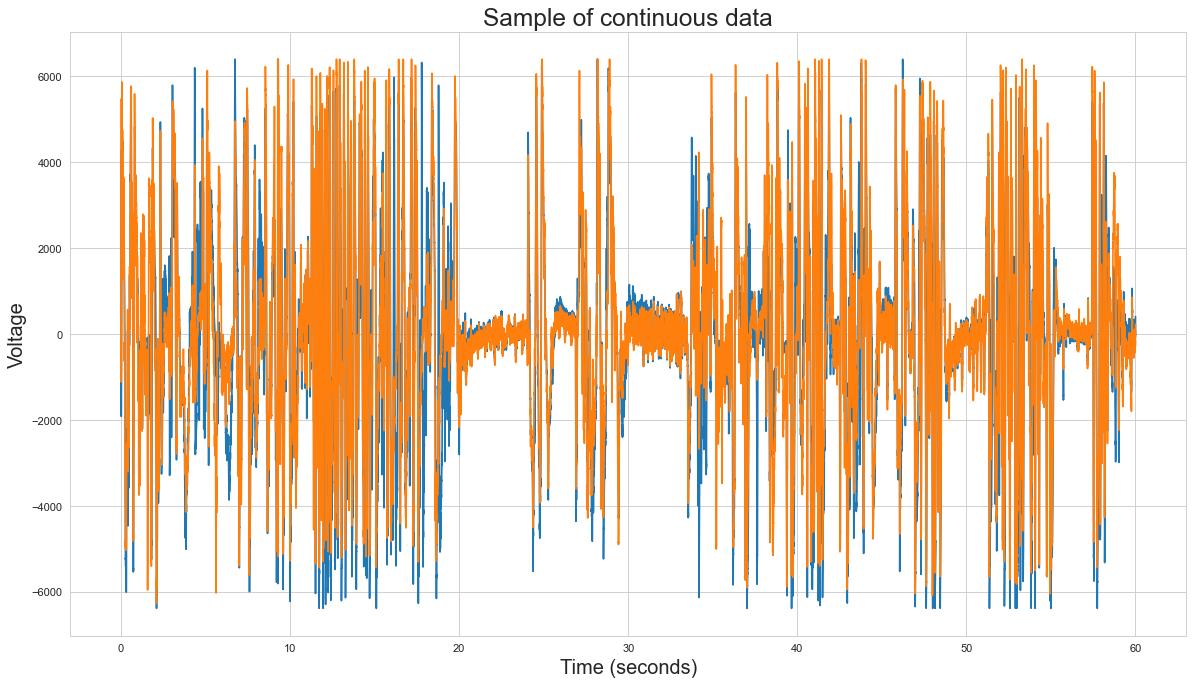

In [23]:
#Here I am plotting a sample of the raw trace continuous data (first 100 indeces)
#Here you can set the channel you want to plot
print(np.shape(dataPre))
channel = 1
plt.figure(figsize=(18, 10), dpi=80)
ax = plt.plot(timeaxis, dataPre[:,2 - 1])
ax1 = plt.plot(timeaxis, dataPre[:,3 - 1])

plt.xlabel('Time (seconds)', fontsize=18)
plt.ylabel('Voltage', fontsize=18)
#plt.legend("channels")
plt.title("Sample of continuous data", fontsize=22)
plt.ylim()

#Always have legend, x and y label and title


# Part 4: Plotting frequency content

Text(0, 0.5, 'PSD')

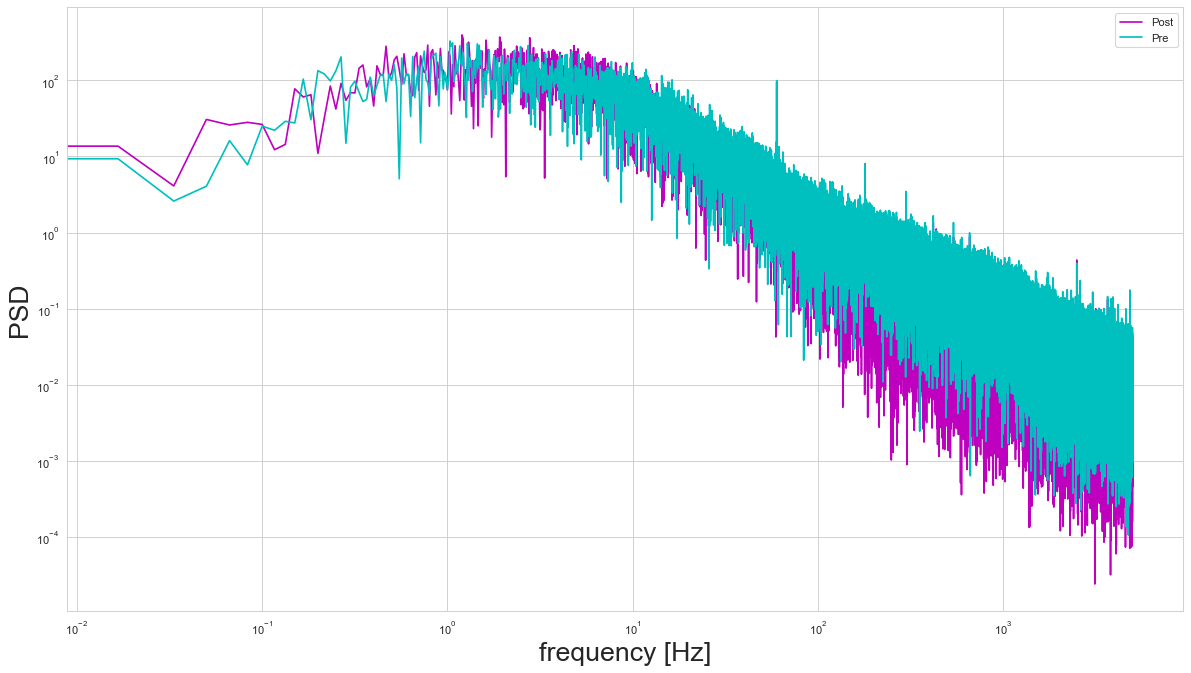

In [24]:
#different method for calculaing fft
pxxPre = np.fft.fft(dataPre[:,1],axis=0)
pxxPost = np.fft.fft(dataPost[:,1],axis=0)
N=np.array(np.shape(timeaxis))[0]
hz = np.linspace(0.0, 1.0/(2.0*(timeaxis[1]-timeaxis[0])), (N)//2)
plt.figure(figsize=(18, 10), dpi=80) #figure size
ax=plt.loglog(hz, 2.0/N * np.abs(pxxPre[:N//2]),color='m') #loglog plot
plt.loglog(hz, 2.0/N * np.abs(pxxPost[:N//2]),color='c') #loglog plot
plt.legend({'Pre','Post'})
plt.xlabel("frequency [Hz]", fontsize=24)
plt.ylabel("PSD", fontsize=24)

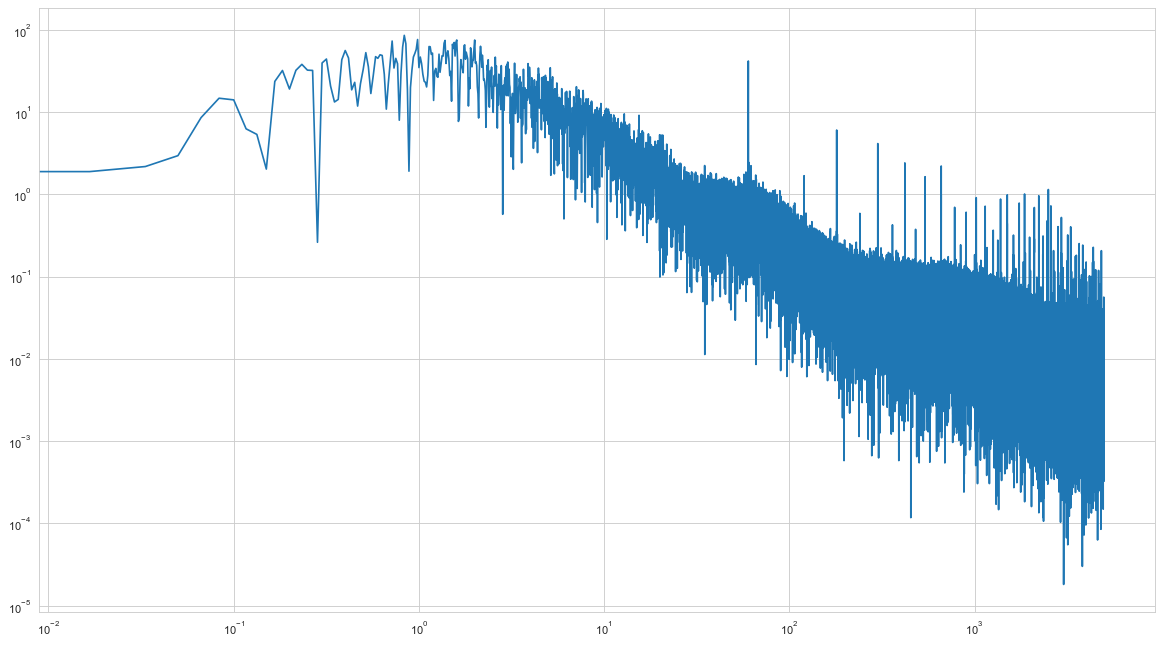

In [25]:
#different method for calculaing fft
channel=1
pxx = np.fft.fft(dataPre[:,channel-1])
N=np.array(np.shape(timeaxis))[0]
hz = np.linspace(0.0, 1.0/(2.0*(timeaxis[1]-timeaxis[0])), (N)//2)
plt.figure(figsize=(18, 10), dpi=80) #figure size
plt.loglog(hz, 2.0/N * np.abs(pxx[:N//2])) #loglog plot

/var/folders/m2/t77nt2r17_v70j9zp21pq6fm0000gn/T/ipykernel_33890/3451789872.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,samplingrate/2])


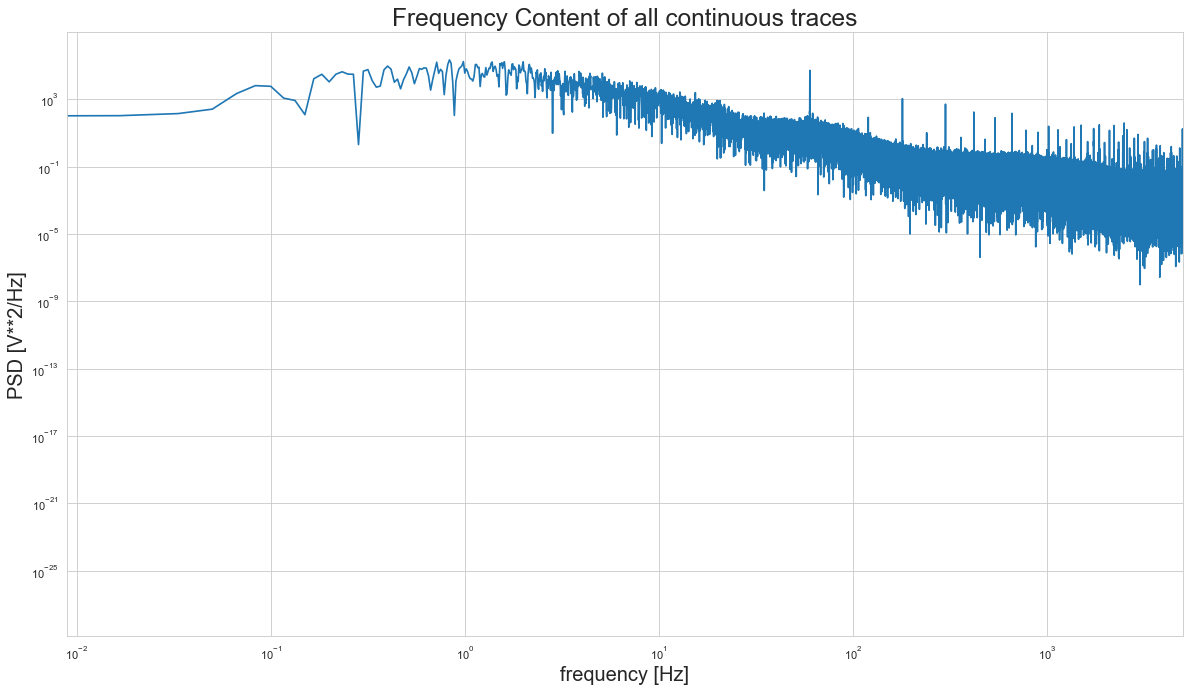

In [26]:
#Frequency Content Code
channel = 1

(f, S) = sc.signal.periodogram(dataPre[:,channel-1], samplingrate, scaling='density')

plt.figure(figsize=(18, 10), dpi=80) #figure size
plt.loglog(f, S) #loglog plot
#plt.ylim([1e-7, 1e4]) #upper and lower limits of plot y axis
plt.xlim([0,samplingrate/2])
plt.xlabel('frequency [Hz]', fontsize=18)
plt.ylabel('PSD [V**2/Hz]', fontsize=18)
plt.title('Frequency Content of all continuous traces', fontsize=22)
plt.ylim()
plt.show()

#question for jonah -- how to isolate a single electrode for this analysis

# Part 5: Applying bandpass filters
### In this section we are applying band pass filters to raw data to determine bands


## Part 5.1 Setting upper and lower limits for neural bands

In [27]:
ISA = [0.01,0.08]
Delta = [1,3 ]
Theta = [4,8]
Alpha = [8,12]
Beta = [12,20]
Gamma = [30,100]
order = 3

#set sampling rate for data youre processing
samplingrate = 10000

In [28]:
idealOrder=np.log10(Beta[1]/Beta[0])/(2 * np.log10(np.sqrt(100)))
idealOrder

0.1109243748081782

In [29]:
isa=np.zeros((int(np.shape(dataPre)[0]/samplingrate),16))
betaPre=np.zeros((int(np.shape(dataPre)[0]/ (samplingrate/Beta[1]*.5)),16))
alphaPre=np.zeros((int(np.shape(dataPre)[0]/ (samplingrate/Alpha[1]*.5)),16))
thetaPre=np.zeros((int(np.shape(dataPre)[0]/ (samplingrate/Theta[1]*.5)),16))
deltaPre=np.zeros((int(np.shape(dataPre)[0]/ (samplingrate/Delta[1]*.5)),16))
gammaPre=np.zeros((int(np.shape(dataPre)[0]/ (samplingrate/Gamma[1]*.5)),16))


betaPost=np.zeros((int(np.shape(dataPost)[0]/ (samplingrate/Beta[1]*.5)),16))
alphaPost=np.zeros((int(np.shape(dataPost)[0]/ (samplingrate/Alpha[1]*.5)),16))
thetaPost=np.zeros((int(np.shape(dataPost)[0]/ (samplingrate/Theta[1]*.5)),16))
deltaPost=np.zeros((int(np.shape(dataPost)[0]/ (samplingrate/Delta[1]*.5)),16))
gammaPost=np.zeros((int(np.shape(dataPost)[0]/ (samplingrate/Gamma[1]*.5)),16))

## Part 5.3

In [30]:
#Set your sampling frequency
fs = 10000  # sampling frequency in Hz
order = 2  # filter order
nyquist = 0.5 * samplingrate
for i in np.arange(1,16):

    #Beta
    low = Beta[0] / nyquist
    high = Beta[1]  / nyquist
    b, a = signal.butter(2, [low, high], btype='band')
    tmpPre = signal.filtfilt(b, a, dataPre[:,i])
    tmpPost = signal.filtfilt(b, a, dataPost[:,i])
    betaPre[:,i]=    signal.resample(tmpPre,int(Beta[1]*2*np.shape(dataPre)[0]/samplingrate))
    betaPost[:,i]=    signal.resample(tmpPost,int(Beta[1]*2*np.shape(dataPost)[0]/samplingrate))

    #Alpha
    low = Alpha[0] / nyquist
    high = Alpha[1]  / nyquist
    b, a = signal.butter(2, [low, high], btype='band')
    tmpPre = signal.filtfilt(b, a, dataPre[:,i])
    tmpPost = signal.filtfilt(b, a, dataPost[:,i])
    alphaPre[:,i]=    signal.resample(tmpPre,int(Alpha[1]*2*np.shape(dataPre)[0]/samplingrate))
    alphaPost[:,i]=    signal.resample(tmpPost,int(Alpha[1]*2*np.shape(dataPost)[0]/samplingrate))

    #Theta
    low = Theta[0] / nyquist
    high = Theta[1]  / nyquist
    b, a = signal.butter(2, [low, high], btype='band')
    tmpPre = signal.filtfilt(b, a, dataPre[:,i])
    tmpPost = signal.filtfilt(b, a, dataPost[:,i])
    thetaPre[:,i]=    signal.resample(tmpPre,int(Theta[1]*2*np.shape(dataPre)[0]/samplingrate))
    thetaPost[:,i]=    signal.resample(tmpPost,int(Theta[1]*2*np.shape(dataPost)[0]/samplingrate))
    #Delta
    low = Delta[0] / nyquist
    high = Delta[1]  / nyquist
    b, a = signal.butter(2, [low, high], btype='band')
    tmpPre = signal.filtfilt(b, a, dataPre[:,i])
    tmpPost = signal.filtfilt(b, a, dataPost[:,i])
    deltaPre[:,i]=    signal.resample(tmpPre,int(Delta[1]*2*np.shape(dataPre)[0]/samplingrate))
    deltaPost[:,i]=    signal.resample(tmpPost,int(Delta[1]*2*np.shape(dataPost)[0]/samplingrate))

    #Gamma
    low = Gamma[0] / nyquist
    high = Gamma[1]  / nyquist
    b, a = signal.butter(2, [low, high], btype='band')
    tmpPre = signal.filtfilt(b, a, dataPre[:,i])
    tmpPost = signal.filtfilt(b, a, dataPost[:,i])

    gammaPre[:,i]=    signal.resample(tmpPre,int(Gamma[1]*2*np.shape(dataPre)[0]/samplingrate))
    gammaPost[:,i]=    signal.resample(tmpPost,int(Gamma[1]*2*np.shape(dataPost)[0]/samplingrate))


Text(0, 0.5, 'Voltage')

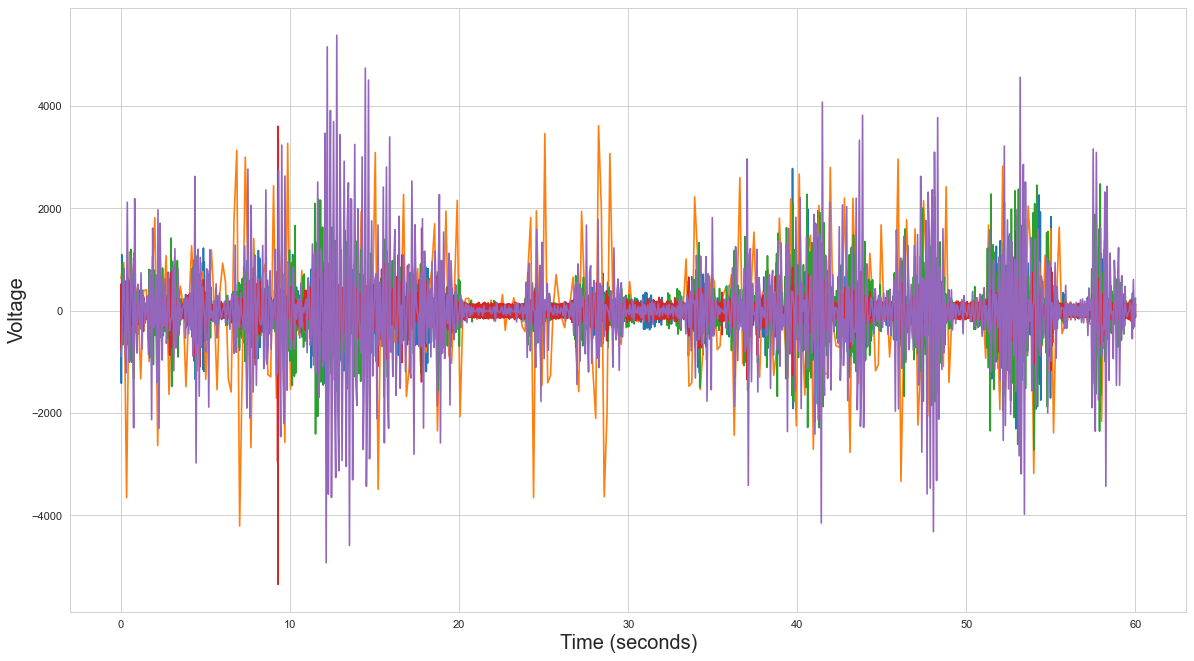

In [31]:
plt.figure(figsize=(18, 10), dpi=80) #figure size
plt.plot(np.linspace(0,60,np.shape(betaPost)[0]),betaPre[:,1])
plt.plot(np.linspace(0,60,np.shape(deltaPost)[0]),deltaPre[:,1])
plt.plot(np.linspace(0,60,np.shape(alphaPost)[0]),alphaPre[:,1])
plt.plot(np.linspace(0,60,np.shape(gammaPost)[0]),gammaPre[:,1])
plt.plot(np.linspace(0,60,np.shape(thetaPost)[0]),thetaPre[:,1])

plt.xlabel('Time (seconds)', fontsize=18)
plt.ylabel('Voltage', fontsize=18)

In [32]:
change=np.zeros((5,16))


change[0,:]=np.var(gammaPost)-np.var(gammaPre,axis=0)
change[1,:]=np.var(betaPost)-np.var(betaPre,axis=0)
change[2,:]=np.var(alphaPost)-np.var(alphaPre,axis=0)
change[3,:]=np.var(thetaPost)-np.var(thetaPre,axis=0)
change[4,:]=np.var(deltaPost)-np.var(deltaPre,axis=0)

/var/folders/m2/t77nt2r17_v70j9zp21pq6fm0000gn/T/ipykernel_33890/2848486251.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


([<matplotlib.axis.YTick at 0x7f884a626850>,
 [Text(0, 0, 'Gamma'),
  Text(0, 1, 'Beta'),
  Text(0, 2, 'Alpha'),
  Text(0, 3, 'Theta'),
  Text(0, 4, 'Delta')])

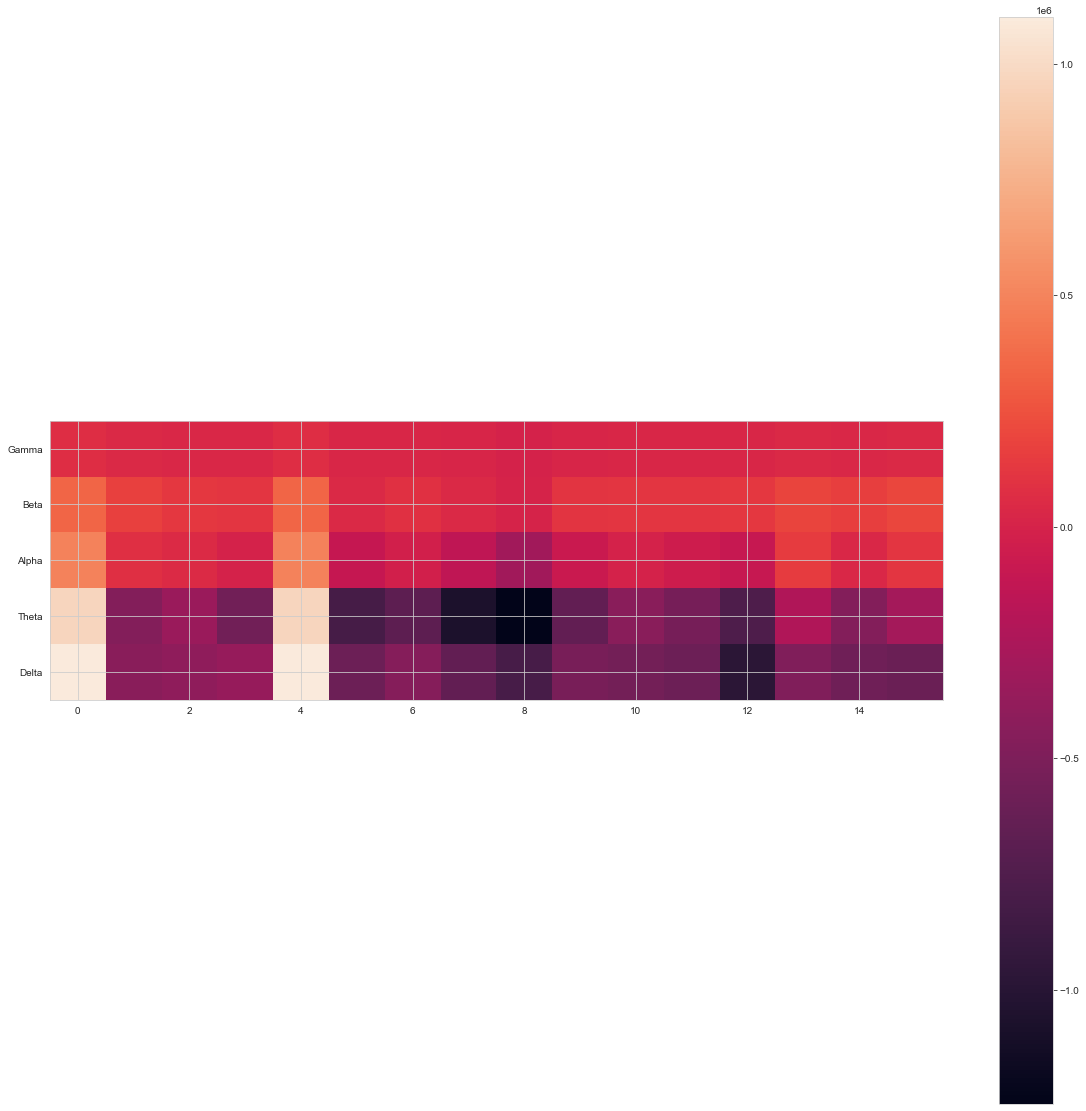

In [41]:
plt.figure(figsize=(20, 20)) #figure size
plt.imshow(change)
plt.colorbar()
plt.yticks(ticks=np.arange(5),labels=("Gamma",'Beta','Alpha','Theta', "Delta"))

In [20]:
change[1]=np.sum()

betaPost=
alphaPost=np.zeros((int(np.shape(data)[0]/ (samplingrate/Alpha[1]*.5)),16))
thetaPost=np.zeros((int(np.shape(data)[0]/ (samplingrate/Theta[1]*.5)),16))
deltaPost=np.zeros((int(np.shape(data)[0]/ (samplingrate/Delta[1]*.5)),16))
gammaPost=np.zeros((int(np.shape(data)[0]/ (samplingrate/Gamma[1]*.5)),16))

SyntaxError: invalid syntax (520755065.py, line 3)

# Part 6: Load and visualizing spike data

## Part 6.1 Load spike data

In [ ]:
#user input
electrodeNum=1; #which electode do you want to get spikes from?


spikes = recording.spikes[electrodeNum-1].sample_numbers #custers, waveforms
time = recording.spikes[electrodeNum-1].timestamps #custers, waveforms
data = recording.spikes[electrodeNum-1].waveforms #why are there 40 of these...
clusters=recording.spikes[electrodeNum-1].clusters
time[-1]/60 #this should be the amount of time of the recording in minutes (divide by 60 to get the length of the recording)

In [ ]:
#Processing spike data for graphing
#Longer explanation needed here

spikePerSec = np.zeros(int(np.floor(time[-1]))) #initializing

seconds = range(int(np.floor(time[-1])))
for i in seconds:
    indices = np.argwhere((time>i-1) & (time<i))
    spikePerSec[i] = np.shape(indices)[0]

# Part 6.2: Plot Spike data into bins of spikes/min

In [ ]:
#Legit spikes per second; based on the assumption that the timestamps are an accurate reflection of time passed
plt.figure(figsize=(14, 9), dpi=80)
plt.plot(spikePerSec)
plt.title("Spike per second", fontsize=20)
plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xlim(0 ,250)
plt.show()

LFP Bands (start new code:)